# CS436: Computer Vision Fundamentals - Project Phase / Week 1 
## 3D Scene Reconstruction and Virtual Tour

#### Name: Syed Muhammad Ashhar Shah
#### Roll Number: 25-03-0009
#### Program: MS-CS

# PHASE 1 (11th November 2025)
---

### Tasks Completed In This Phase

- **Dataset Selection - Your first task is to build the foundational block of any SfM system by implementing a two-view reconstruction pipeline. To begin, you must capture a suitable image pair that provides parallax; do not simply rotate the camera in one spot, but instead physically move it between shots, such as taking one large step to the side while keeping the target object in frame.**
    - The dataset for this project was taken from the back-entrance of the Tehzeeb building that is located in DHA Phase 5, Lahore. The pictures were captured during the day when the sun was hitting the building to maximize the calrity of the features during feature extraction & feature matching processes.

- **Feature Matching - With this data, you will detect and match features between the two images using SIFT or ORB, filtering for high-quality matches with Lowe’s ratio test.**
    - SIFT feature matching was used to fetch keypoints / features from each image and were then matched with each other using a FLANN-based matcher where the KD-Tree algorithm was selected and the number of KD-trees to build was set to 5, each tree was checked recursively 50 times. For each descriptor in image 1, we find its two nearest neighbors (k=2) in image 2 based on the Euclidean distance.
    - Lowe’s Ratio Test is also applied to help eliminate ambiguous matches where for each match we check the distance between them. If if the ratio of the distances between the two is less than the ratio threshold,then the match is accepted

## Define Imports
- The required libraries for the code are imported here.

In [1]:
import os
import cv2
import numpy as np
from natsort import natsorted
import matplotlib.pyplot as plt

## Configure Variables
- The variables that are to be used throughout the code are specified here.

In [ ]:
input_dir = r"../Tehzeeb_v2"
output_dir = r"../Tehzeeb_v2/resized_images"
target_size = (1080, 1440)
os.makedirs(output_dir, exist_ok=True)

processNImages = 10
featureMatchNImages = 5

## Fetch & Read The First N Images
- Fetch the individual images paths in the specified image directory.
- Use the NatSort libaray to sort all the image paths correctly.
- Only select the first N images specified in the configuration.

In [3]:
image_paths = []

for f in os.listdir(input_dir):
    ext = os.path.splitext(f)[1]
    if (ext == ".jpg"):
        full_path = os.path.join(input_dir, f)
        image_paths.append(full_path)

image_paths = natsorted(image_paths)

#### Display For Validation

In [4]:
print(f"Found {len(image_paths)} images in {input_dir}")
image_paths = image_paths[:processNImages]
print(f"Fetching First {len(image_paths)} images in {input_dir}")

Found 20 images in Tehzeeb_v2
Fetching First 10 images in Tehzeeb_v2


## Apply Pre-Processing To The Images
- Read the images using cv2.imread()
- Apply resizing to the iamges (keeping the aspect ratio same - 3:4) using cv2.resize()
- Save the resized images in the resize output directory

In [5]:
# iterate over all the image paths
for i, path in enumerate(image_paths, start=1):
    # read the image
    img = cv2.imread(path)
    if img is None:
        print(f"Can Not Open File: {path}")
        continue
    # resize images to the desired size
    resized = cv2.resize(img, target_size)
    filename = os.path.basename(path)
    save_path = os.path.join(output_dir, filename)
    # write the resized image to the output folder
    cv2.imwrite(save_path, resized)
    print(f"[{i}/{len(image_paths)}] Saved resized image: {save_path}")

[1/10] Saved resized image: Tehzeeb_v2/resized_images/IMG_20251112_112433.jpg
[2/10] Saved resized image: Tehzeeb_v2/resized_images/IMG_20251112_112440.jpg
[3/10] Saved resized image: Tehzeeb_v2/resized_images/IMG_20251112_112446.jpg
[4/10] Saved resized image: Tehzeeb_v2/resized_images/IMG_20251112_112453.jpg
[5/10] Saved resized image: Tehzeeb_v2/resized_images/IMG_20251112_112501.jpg
[6/10] Saved resized image: Tehzeeb_v2/resized_images/IMG_20251112_112507.jpg
[7/10] Saved resized image: Tehzeeb_v2/resized_images/IMG_20251112_112512.jpg
[8/10] Saved resized image: Tehzeeb_v2/resized_images/IMG_20251112_112518.jpg
[9/10] Saved resized image: Tehzeeb_v2/resized_images/IMG_20251112_112524.jpg
[10/10] Saved resized image: Tehzeeb_v2/resized_images/IMG_20251112_112528.jpg


#### Display For Validation

In [6]:
print("\nAll images resized and saved to:", output_dir)


All images resized and saved to: Tehzeeb_v2/resized_images


## Display The First N Images
- Fetch the resized image paths and sort via NatSorted.
- Load the resized images.
- Use matplotlib to display the first N images in a grid like format (5 columns, N/5 rows)

#### Fetch Resized Paths

In [7]:
resized_paths = []

# fetch the final paths of all the resized images
for f in os.listdir(output_dir):
    ext = os.path.splitext(f)[1]
    if (ext == ".jpg"):
        full_path = os.path.join(output_dir, f)
        resized_paths.append(full_path)

# sort the paths according to the file names
resized_paths = natsorted(resized_paths)

#### Open & Store Each Images

In [8]:
images = []

# open each image path and store the resultant images in a list
for img_path in resized_paths:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)

#### Display The First N-Images


Displaying first 10 images...


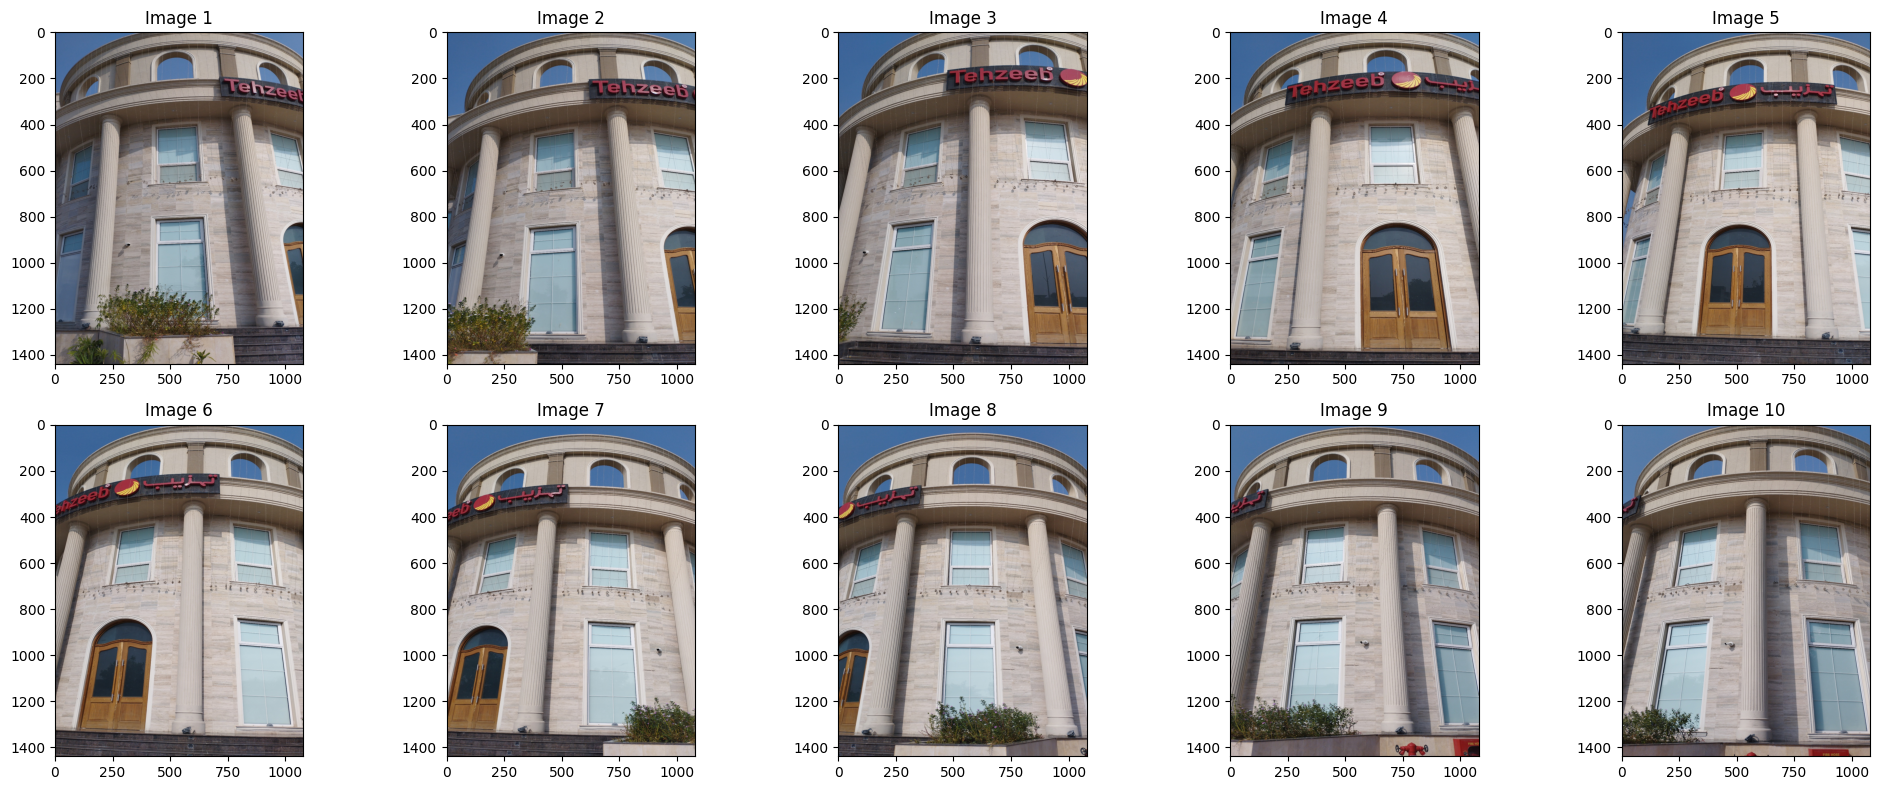

In [9]:
# function to show the images
print(f"\nDisplaying first {processNImages} images...")

# define grid-like formatting
rows = int(processNImages / 5)
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
axes = axes.flatten()

# loop over and display each image
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

## Compute Features & Perform Feature Matching Between Two Consecutive Images
- Compute features between the two images using OpenCV's SIFT feature detector
- Detect matches between two images using OpenCV's FLANN feature matches detector
- Apply lowes ratio test between the two matches to further filter good matches
- Display a subset of the matched images with the match lines in between

#### Function To Compute Features (Keypoints & Descriptors)

In [10]:
def compute_features(image):
    gray_scaled = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray_scaled, None)
    return keypoints, descriptors

#### Function To Compute Matches Between Two Images (Uses Lowes Ratio Test)

In [11]:
def compute_matches(descriptor1, descriptor2, ratio=0.75):
    # matcher configurations
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    # initialize matcher
    flann_matcher = cv2.FlannBasedMatcher(index_params, search_params)
    # identify matches
    matches_found = flann_matcher.knnMatch(descriptor1, descriptor2, k=2)
    # apply lowes ratio test using ratio threshold
    final_matches = []
    for m, n in matches_found:
        if m.distance < ratio * n.distance:
            final_matches.append(m)
    return final_matches

Found 512 Matches B/W Image 1 & Image 2


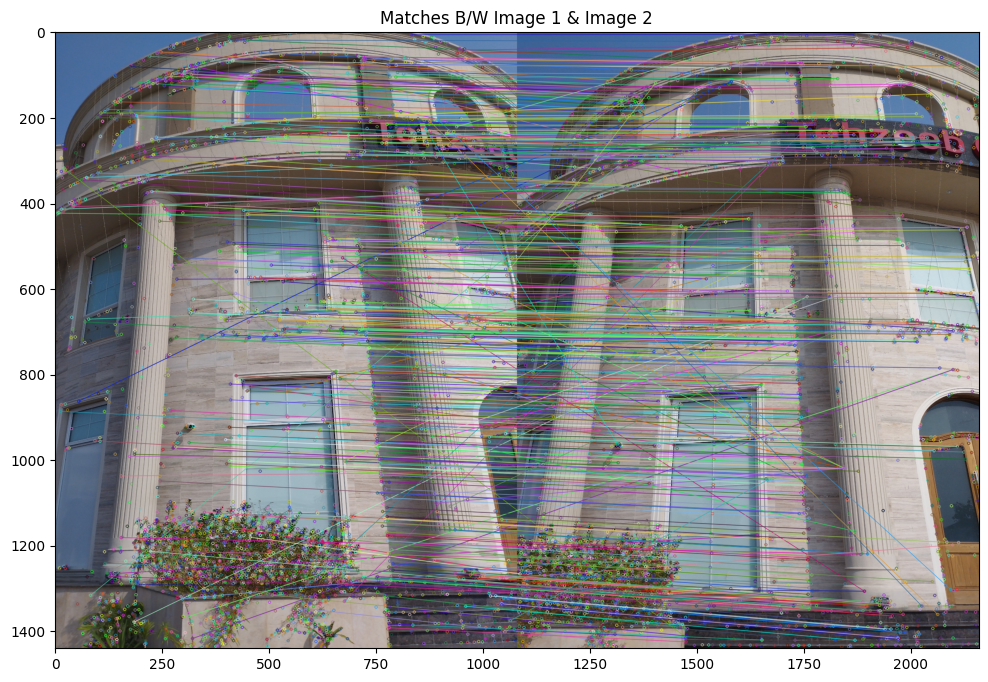





Found 529 Matches B/W Image 2 & Image 3


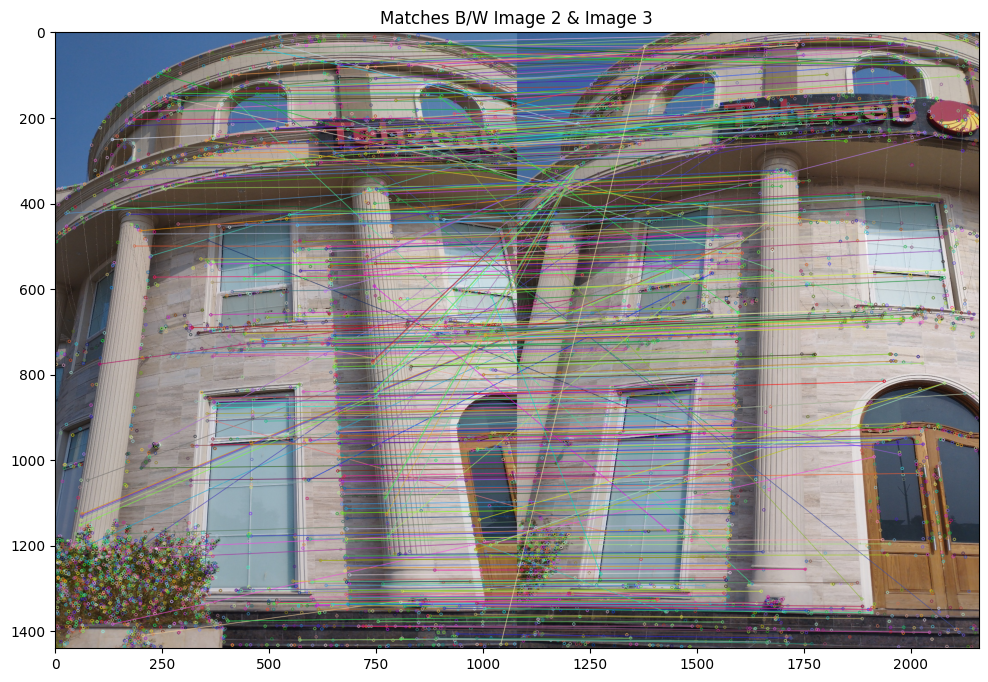





Found 423 Matches B/W Image 3 & Image 4


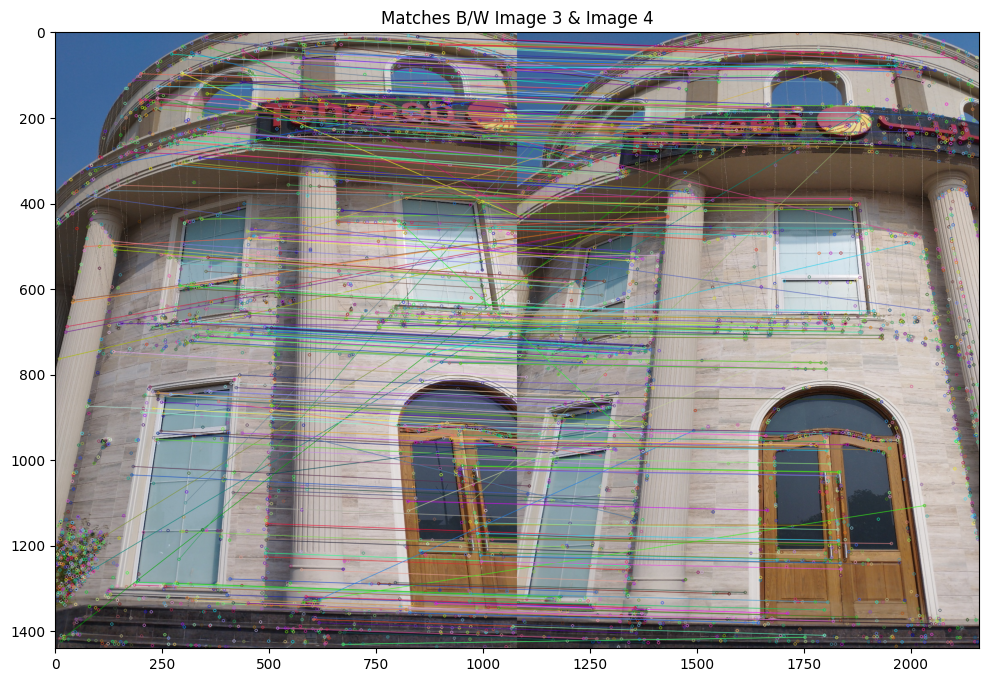





Found 336 Matches B/W Image 4 & Image 5


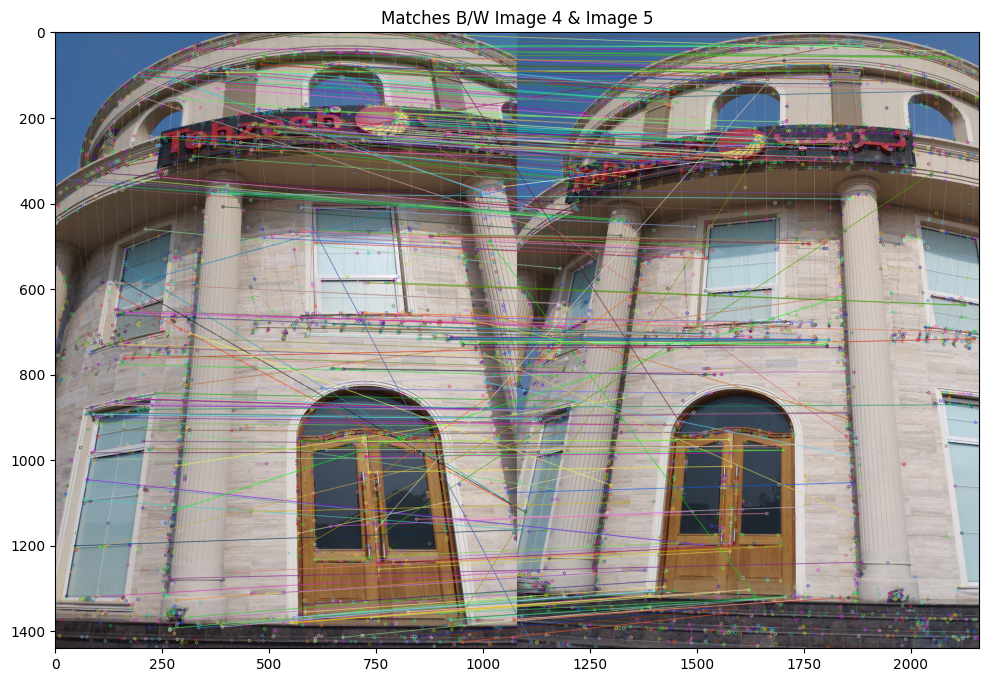





Found 486 Matches B/W Image 5 & Image 6


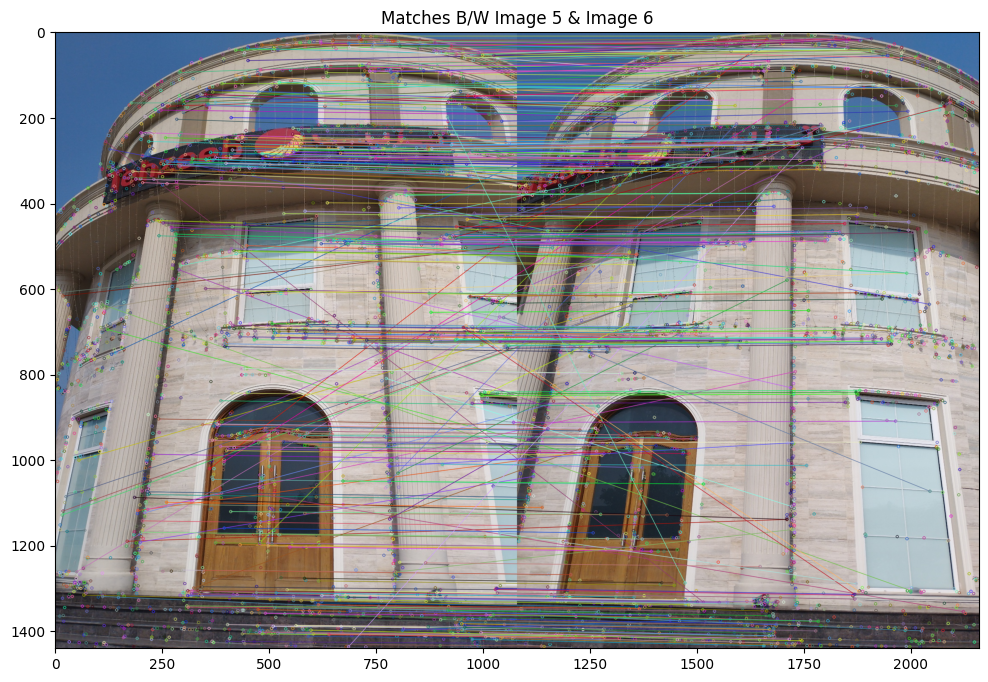

In [12]:
# loop over all the images
for i in range(featureMatchNImages):
    
    # fetch features for the current image and the next image
    kp1, desc1 = compute_features(images[i])
    kp2, desc2 = compute_features(images[i + 1])
    
    # find feature matching between the two images
    matches = compute_matches(desc1, desc2)
    
    print(f"Found {len(matches)} Matches B/W Image {i+1} & Image {i+2}")
    
    # draw the matches and send store the image with matches
    matches_visualized = cv2.drawMatches(images[i], kp1, images[i + 1], kp2, matches, None)
    
    # display the image
    plt.figure(figsize=(20, 8))
    plt.imshow(matches_visualized)
    plt.title(f"Matches B/W Image {i+1} & Image {i+2}")
    plt.show()
    print("\n\n\n")